## Machine Learning - XGboost

#### Importación de librerías

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV as GridSearch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve,roc_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

/home/grobles/FIUBA/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Importación de features

In [2]:
features = pd.read_csv('../features/features_todos.csv')
features.shape

(38829, 92)

In [3]:
pd.set_option('display.max_rows', 100)
features.dtypes

person                                    object
marca_favorita_apple                       int64
marca_favorita_asus                        int64
marca_favorita_lenovo                      int64
marca_favorita_lg                          int64
marca_favorita_motorola                    int64
marca_favorita_no_tiene                    int64
marca_favorita_quantum                     int64
marca_favorita_samsung                     int64
marca_favorita_sony                        int64
nivel_de_actividad_muy_bajo                int64
nivel_de_actividad_bajo                    int64
nivel_de_actividad_medio                   int64
nivel_de_actividad_alto                    int64
nivel_de_actividad_muy_alto                int64
dias_en_plataforma                       float64
dias_distintos_con_eventos                 int64
eventos_totales_generados                  int64
cant_accesos_southeast                     int64
cant_accesos_northeast                     int64
cant_accesos_south  

#### Categorización de features categóricos

In [4]:
# Según Marca
features['marca_favorita_apple'] = features['marca_favorita_apple'].astype('category')
features['marca_favorita_asus'] = features['marca_favorita_asus'].astype('category')
features['marca_favorita_lenovo'] = features['marca_favorita_lenovo'].astype('category')
features['marca_favorita_lg'] = features['marca_favorita_lg'].astype('category')
features['marca_favorita_motorola'] = features['marca_favorita_motorola'].astype('category')
features['marca_favorita_no_tiene'] = features['marca_favorita_no_tiene'].astype('category')
features['marca_favorita_quantum'] = features['marca_favorita_quantum'].astype('category')
features['marca_favorita_samsung'] = features['marca_favorita_samsung'].astype('category')
features['marca_favorita_sony'] = features['marca_favorita_sony'].astype('category')

features['cant_modelo_iphone'] = features['cant_modelo_iphone'].astype('category')
features['cant_modelo_samsung'] = features['cant_modelo_samsung'].astype('category')
features['cant_modelo_motorola'] = features['cant_modelo_motorola'].astype('category')
features['cant_modelo_otro'] = features['cant_modelo_otro'].astype('category')
features['modelo_moda'] = features['modelo_moda'].astype('category')

features['porcentaje_modelo_iphone'] = features['porcentaje_modelo_iphone'].astype('category')
features['porcentaje_modelo_samsung'] = features['porcentaje_modelo_samsung'].astype('category')
features['porcentaje_modelo_motorola'] = features['porcentaje_modelo_motorola'].astype('category')
features['porcentaje_modelo_otro'] = features['porcentaje_modelo_otro'].astype('category')

# Nivel de Actividad
features['nivel_de_actividad_muy_bajo'] = features['nivel_de_actividad_muy_bajo'].astype('category')
features['nivel_de_actividad_bajo'] = features['nivel_de_actividad_bajo'].astype('category')
features['nivel_de_actividad_medio'] = features['nivel_de_actividad_medio'].astype('category')
features['nivel_de_actividad_alto'] = features['nivel_de_actividad_alto'].astype('category')
features['nivel_de_actividad_muy_alto'] = features['nivel_de_actividad_muy_alto'].astype('category')
features['has_converted_before'] = features['has_converted_before'].astype('category')
features['month_moda'] = features['month_moda'].astype('category')
features['completa_flujo'] = features['completa_flujo'].astype('category')
# No es Categorico: features['dias_en_plataforma'] = features['dias_en_plataforma'].astype('category')
# No es Categorico: features['dias_distintos_con_eventos'] = features['dias_distintos_con_eventos'].astype('category')
# No es Categorico: features['eventos_totales_generados'] = features['eventos_totales_generados'].astype('category')
# No es Categorico: features['first_and_last_event_distance_in_days'] = features['first_and_last_event_distance_in_days'].astype('category')
# No es Categorico: features['mean_events_per_day'] = features['mean_events_per_day'].astype('category')
# No es Categorico: features['most_viewed_sku'] = features['most_viewed_sku'].astype('category')
# No es Categorico: features['most_viewed_color_Preto'] = features['most_viewed_color_Preto'].astype('category')
# No es Categorico: features['most_viewed_color_Branco'] = features['most_viewed_color_Branco'].astype('category')
# No es Categorico: features['most_viewed_color_Dourado'] = features['most_viewed_color_Dourado'].astype('category')
# No es Categorico: features['most_viewed_sky'] = features['most_viewed_sky'].astype('category')
# No es Categorico: features['cantidad_checkouts'] = features['cantidad_checkouts'].astype('category')
# No es Categorico: features['tasa_cc'] = features['tasa_cc'].astype('category')


# Según Dispositivo
features['favorite_device_computer'] = features['favorite_device_computer'].astype('category')
features['favorite_device_smartphone'] = features['favorite_device_smartphone'].astype('category')
features['favorite_device_tablet'] = features['favorite_device_tablet'].astype('category')
features['favorite_device_unknown'] = features['favorite_device_unknown'].astype('category')


# Accesos Según Región
# No es Categorico: features['cant_accesos_southeast'] = features['cant_accesos_southeast'].astype('category')
# No es Categorico: features['cant_accesos_northeast'] = features['cant_accesos_northeast'].astype('category')
# No es Categorico: features['cant_accesos_south'] = features['cant_accesos_south'].astype('category')
# No es Categorico: features['cant_accesos_center_west'] = features['cant_accesos_center_west'].astype('category')
# No es Categorico: features['cant_accesos_north'] = features['cant_accesos_north'].astype('category')

# Eventos Según Franja Horaria
# No es Categorico: features['cant_ev_madrugada'] = features['cant_ev_madrugada'].astype('category')
# No es Categorico: features['cant_ev_manana'] = features['cant_ev_manana'].astype('category')
# No es Categorico: features['cant_ev_tarde'] = features['cant_ev_tarde'].astype('category')
# No es Categorico: features['cant_ev_noche'] = features['cant_ev_noche'].astype('category')
features['franja_horaria_moda'] = features['franja_horaria_moda'].astype('category')

# Según Estado del Celular
# No es Categorico: features['cant_buenos'] = features['cant_buenos'].astype('category')
# No es Categorico: features['cant_excelentes'] = features['cant_excelentes'].astype('category')
# No es Categorico: features['cant_muy_buenos'] = features['cant_muy_buenos'].astype('category')
# No es Categorico: features['cant_nuevos'] = features['cant_nuevos'].astype('category')
features['condicion_de_producto_moda'] = features['condicion_de_producto_moda'].astype('category')

# Según Semana del Mes
# No es Categorico: features['cant_ev_primer_semana_mes'] = features['cant_ev_primer_semana_mes'].astype('category')
# No es Categorico: features['cant_ev_segunda_semana_mes'] = features['cant_ev_segunda_semana_mes'].astype('category')
# No es Categorico: features['cant_ev_tercera_semana_mes'] = features['cant_ev_tercera_semana_mes'].astype('category')
# No es Categorico: features['cant_ev_cuarta_semana_mes'] = features['cant_ev_cuarta_semana_mes'].astype('category')
features['semana_del_mes_moda'] = features['semana_del_mes_moda'].astype('category')
# No es Categorico: features['porcentaje_eventos_en_fin_de_semana'] = features['porcentaje_eventos_en_fin_de_semana'].astype('category')

# Interes En Los Últimos Días
# No es Categorico: features['interest_last_2_days'] = features['interest_last_2_days'].astype('category')
# No es Categorico: features['interest_last_4_days'] = features['interest_last_4_days'].astype('category')
# No es Categorico: features['interest_last_6_days'] = features['interest_last_6_days'].astype('category')
# No es Categorico: features['interest_last_8_days'] = features['interest_last_8_days'].astype('category')
# No es Categorico: features['interest_last_10_days'] = features['interest_last_10_days'].astype('category')
# No es Categorico: features['interest_last_12_days'] = features['interest_last_12_days'].astype('category')
# No es Categorico: features['interest_last_14_days'] = features['interest_last_14_days'].astype('category')
# No es Categorico: features['interest_last_16_days'] = features['interest_last_16_days'].astype('category')
# No es Categorico: features['interest_last_18_days'] = features['interest_last_18_days'].astype('category')
# No es Categorico: features['interest_last_20_days'] = features['interest_last_20_days'].astype('category')
# No es Categorico: features['interest_last_22_days'] = features['interest_last_22_days'].astype('category')
# No es Categorico: features['interest_last_24_days'] = features['interest_last_24_days'].astype('category')
# No es Categorico: features['interest_last_26_days'] = features['interest_last_26_days'].astype('category')
# No es Categorico: features['interest_last_28_days'] = features['interest_last_28_days'].astype('category')
# No es Categorico: features['interest_last_30_days'] = features['interest_last_30_days'].astype('category')

# Cantidad Total de Eventos

# No es Categorico: features['ad_campaign_hit'] = features['ad_campaign_hit'].astype('category')
# No es Categorico: features['brand_listing'] = features['brand_listing'].astype('category')
# No es Categorico: features['checkout'] = features['checkout'].astype('category')
# No es Categorico: features['conversion'] = features['conversion'].astype('category')
# No es Categorico: features['generic_listing'] = features['generic_listing'].astype('category')
# No es Categorico: features['lead'] = features['lead'].astype('category')
# No es Categorico: features['search_engine_hit'] = features['search_engine_hit'].astype('category')
# No es Categorico: features['searched_products'] = features['searched_products'].astype('category')
# No es Categorico: features['staticpage_ev'] = features['staticpage_ev'].astype('category')
# No es Categorico: features['viewed_product'] = features['viewed_product'].astype('category')
# No es Categorico: features['visited_site'] = features['visited_site'].astype('category')
# No es Categorico: features['cant_total_eventos'] = features['cant_total_eventos'].astype('category')

In [5]:
features.head()

,person,marca_favorita_apple,marca_favorita_asus,marca_favorita_lenovo,marca_favorita_lg,marca_favorita_motorola,marca_favorita_no_tiene,marca_favorita_quantum,marca_favorita_samsung,marca_favorita_sony,...,searched_products,ad_campaign_hit,staticpage,checkout,search_engine_hit,conversion,generic_listing,brand_listing,visited_site,lead
0,0008ed71,1,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,1,0,2,0
1,00091926,1,0,0,0,0,0,0,0,0,...,0,15,0,2,0,0,0,25,34,0
2,00091a7a,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,5,1,0
3,000ba417,0,0,0,0,0,0,0,1,0,...,0,1,0,6,1,1,14,24,6,0
4,000c79fe,1,0,0,0,0,0,0,0,0,...,9,1,0,1,1,0,1,0,1,0


In [6]:
features.shape

(38829, 92)

Obtengo el **nombre de las columnas** de los features

In [7]:
for column in features.columns:
    print ("'" + column + "'" + ",")


'person',
'marca_favorita_apple',
'marca_favorita_asus',
'marca_favorita_lenovo',
'marca_favorita_lg',
'marca_favorita_motorola',
'marca_favorita_no_tiene',
'marca_favorita_quantum',
'marca_favorita_samsung',
'marca_favorita_sony',
'nivel_de_actividad_muy_bajo',
'nivel_de_actividad_bajo',
'nivel_de_actividad_medio',
'nivel_de_actividad_alto',
'nivel_de_actividad_muy_alto',
'dias_en_plataforma',
'dias_distintos_con_eventos',
'eventos_totales_generados',
'cant_accesos_southeast',
'cant_accesos_northeast',
'cant_accesos_south',
'cant_accesos_center_west',
'cant_accesos_north',
'cant_total_eventos',
'first_and_last_event_distance_in_days',
'mean_events_per_day',
'cant_ev_madrugada',
'cant_ev_manana',
'cant_ev_tarde',
'cant_ev_noche',
'franja_horaria_moda',
'cant_buenos',
'cant_excelentes',
'cant_muy_buenos',
'cant_nuevos',
'condicion_de_producto_moda',
'cant_ev_primer_semana_mes',
'cant_ev_segunda_semana_mes',
'cant_ev_tercera_semana_mes',
'cant_ev_cuarta_semana_mes',
'semana_del_mes_moda'

In [8]:
features_names = [
#'marca_favorita_apple',
#'marca_favorita_asus',
#'marca_favorita_lenovo',
#'marca_favorita_lg',
#'marca_favorita_motorola',
#'marca_favorita_no_tiene',
#'marca_favorita_quantum',
#'marca_favorita_samsung',
#'marca_favorita_sony',
#'nivel_de_actividad_muy_bajo',
#'nivel_de_actividad_bajo',
#'nivel_de_actividad_medio',
#'nivel_de_actividad_alto',
'nivel_de_actividad_muy_alto',
'dias_en_plataforma',
'dias_distintos_con_eventos',
'eventos_totales_generados',
#'cant_accesos_southeast',
'cant_accesos_northeast',
'cant_accesos_south',
#'cant_accesos_center_west',
#'cant_accesos_north',
'cant_total_eventos',
'first_and_last_event_distance_in_days',
'mean_events_per_day',
'cant_ev_madrugada',
'cant_ev_manana',
'cant_ev_tarde',
'cant_ev_noche',
'franja_horaria_moda',
'cant_buenos',
'cant_excelentes',
'cant_muy_buenos',
#'cant_nuevos',
'condicion_de_producto_moda',
'cant_ev_primer_semana_mes',
'cant_ev_segunda_semana_mes',
'cant_ev_tercera_semana_mes',
'cant_ev_cuarta_semana_mes',
'semana_del_mes_moda',
'porcentaje_eventos_en_fin_de_semana',
'cant_modelo_iphone',
'cant_modelo_samsung',
'cant_modelo_motorola',
'cant_modelo_otro',
'porcentaje_modelo_iphone',
'porcentaje_modelo_samsung',
'porcentaje_modelo_motorola',
'porcentaje_modelo_otro',
'modelo_moda',
'interest_last_2_days',
'interest_last_4_days',
'interest_last_6_days',
'interest_last_8_days',
'interest_last_10_days',
'interest_last_12_days',
'interest_last_14_days',
'interest_last_16_days',
'interest_last_18_days',
'interest_last_20_days',
'interest_last_22_days',
'interest_last_24_days',
'interest_last_26_days',
'interest_last_28_days',
'interest_last_30_days',
'has_converted_before',
'most_viewed_sku',
#'most_viewed_color_preto',
#'most_viewed_color_branco',
'most_viewed_color_dourado',
'region_brasil_sao_paulo',
#'region_brasil_unknown',
'region_brasil_minas_gerais',
'tasa_cc',
'month_moda',
#'completa_flujo',
'favorite_device_computer',
'favorite_device_smartphone',
#'favorite_device_tablet',
#'favorite_device_unknown',
'viewed_product',
'searched_products',
'ad_campaign_hit',
'staticpage',
'checkout',
'search_engine_hit',
'conversion',
'generic_listing',
'brand_listing',
'visited_site',
#'lead'

]

### Creación del Training Set

In [9]:
labels_training_set = pd.read_csv('../dataset/labels_training_set.csv')
test_set = pd.read_csv('../dataset/trocafone_kaggle_test.csv')
test_set.shape

(19415, 1)

En **labels_training_set** están los usuarios con los labels, los resultados que conocemos de compras (1) o no (0) en los primeros 15 días de Junio.

En **test_set** están solamente las personas que queremos predecir si compraron o no.

Realizamos un merge entre el modelo con los **features** y **labels_training_set** para generar un modelo completo con los labels, con el fin de entrenar los algoritmos. Este modelo se guarda en **training_set**.

In [10]:
training_set_global = pd.merge(features, labels_training_set, how='inner', on='person')
training_set_global.head()

,person,marca_favorita_apple,marca_favorita_asus,marca_favorita_lenovo,marca_favorita_lg,marca_favorita_motorola,marca_favorita_no_tiene,marca_favorita_quantum,marca_favorita_samsung,marca_favorita_sony,...,ad_campaign_hit,staticpage,checkout,search_engine_hit,conversion,generic_listing,brand_listing,visited_site,lead,label
0,0008ed71,1,0,0,0,0,0,0,0,0,...,0,0,3,0,0,1,0,2,0,0
1,000c79fe,1,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,1,0,0
2,001802e4,1,0,0,0,0,0,0,0,0,...,5,0,1,0,0,4,0,1,0,0
3,0019e639,0,0,0,0,1,0,0,0,0,...,29,0,15,13,2,28,165,19,0,0
4,001b0bf9,0,0,0,0,0,0,0,1,0,...,0,0,2,0,1,1,1,0,0,0


In [11]:
training_set_global.shape

(19414, 93)

Merge de **test_set**, que son las personas que queremos predecir si compraron o no con el resto del modelo con features.

In [12]:
test_set = pd.merge(features, test_set, how='inner', on='person')

Teniendo el **training_set_global** completo, lo dividimos en dos partes:
1. Un training set propiamente dicho.
2. Un test set.

Esto se hace con la función train_test_split, que recibe:

1. x - Arreglo con todas las columnas del training_set original menos la última (que es el label)

2. y - Arreglo con la última columna del training_set original (que es el label)

3. % del tamaño del test set sobre el total del tamaño del training_set original

De yapa:

z - arreglo con todas las columnas del test_set original. Este data frame tiene las predicciones que tenemos que hacer y comparar en Kaggle para obtener el resultado.

In [13]:
x = np.array(training_set_global[features_names])
y = np.array(training_set_global['label'])
z = np.array(test_set[features_names])
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.18)
z.shape

(19415, 71)

### XGBoost + RandomSearch

Defino una función **model_fit()** que recibe el algoritmo clasificador y realiza estas tareas:

1. Fitting: Entrena el algoritmo con el training set X (person + features) e Y (labels)
2. Predicción: Predice los labels en el set de testing
3. Cálculo de accuracy: Calcula el accuracy de la predicción anterior comparando con los labels conocidos (y_test)

La predicción del punto 2 retorna una probabilidad [0, 1] por eso:

4. Clasificación: etiqueta con 0 o 1 dependiendo de la probabilidad.


In [14]:
def modelfit(alg):
    alg.fit(X_train, y_train, eval_metric='aucpr')
    pred = (alg.predict_proba(X_test)[:,1])
    accuracy = accuracy_score(y_test, pred.round(), normalize=False)
    pred_proba = pred
    print("Accuracy: ", accuracy / float(pred.size))

    for i in range(0,pred.size):
        if (pred[i] >= 0.5):
            pred[i] = 1
        else: 
            pred[i] = 0

    print('---Classification Report---')
    print(classification_report(y_test,pred))
    print('AUROC :' + str(roc_auc_score(y_test, pred_proba)))

Defino función Timer que servirá para tomar los tiempos de ejecución de los algoritmos

In [15]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

#### Random Search

Buscaremos los mejores hiperparámetros para XGBoost utilizando la técnica de Random Search, a modo de tener una primera aproximación.

In [16]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 3, 5, 7, 8, 9, 10, 11, 12, 13],
        'gamma': [6, 6.5, 7, 7.5, 8, 10],
        'subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0],
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 9, 10],
        'n_estimators': [650, 675, 700, 725, 750],
        'learning_rate': [0.01, 0.05, 0.08, 0.1],
        'scale_pos_weight' : [3, 5, 8, 10, 12, 15, 20],
        }


# Best hyperparameters:
#{'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}

# Best hyperparameters:
#{'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 8, 'colsample_bytree': 0.8}


In [17]:
xgb1 = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [18]:
folds = 5
param_comb = 50

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb1, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] subsample=1.0, scale_pos_weight=15, n_estimators=675, min_child_weight=13, max_depth=6, learning_rate=0.08, gamma=7.5, colsample_bytree=0.85 
[CV] subsample=1.0, scale_pos_weight=15, n_estimators=675, min_child_weight=13, max_depth=6, learning_rate=0.08, gamma=7.5, colsample_bytree=0.85 
[CV] subsample=1.0, scale_pos_weight=15, n_estimators=675, min_child_weight=13, max_depth=6, learning_rate=0.08, gamma=7.5, colsample_bytree=0.85 
[CV] subsample=1.0, scale_pos_weight=15, n_estimators=675, min_child_weight=13, max_depth=6, learning_rate=0.08, gamma=7.5, colsample_bytree=0.85 
[CV]  subsample=1.0, scale_pos_weight=15, n_estimators=675, min_child_weight=13, max_depth=6, learning_rate=0.08, gamma=7.5, colsample_bytree=0.85, score=0.8247787827536339, total=  43.2s
[CV] subsample=1.0, scale_pos_weight=15, n_estimators=675, min_child_weight=13, max_depth=6, learning_rate=0.08, gamma=7.5, colsample_bytree=0.85 
[CV]  subsample

[CV]  subsample=0.65, scale_pos_weight=12, n_estimators=650, min_child_weight=5, max_depth=3, learning_rate=0.01, gamma=6.5, colsample_bytree=0.7, score=0.8309495796259528, total=  20.8s
[CV] subsample=0.65, scale_pos_weight=12, n_estimators=650, min_child_weight=5, max_depth=3, learning_rate=0.01, gamma=6.5, colsample_bytree=0.7 


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.3min


[CV]  subsample=0.65, scale_pos_weight=12, n_estimators=650, min_child_weight=5, max_depth=3, learning_rate=0.01, gamma=6.5, colsample_bytree=0.7, score=0.856104615535456, total=  21.1s
[CV] subsample=0.65, scale_pos_weight=12, n_estimators=650, min_child_weight=5, max_depth=3, learning_rate=0.01, gamma=6.5, colsample_bytree=0.7 
[CV]  subsample=1.0, scale_pos_weight=15, n_estimators=650, min_child_weight=9, max_depth=6, learning_rate=0.05, gamma=6, colsample_bytree=1.0, score=0.839828908988406, total=  46.1s
[CV] subsample=0.65, scale_pos_weight=12, n_estimators=650, min_child_weight=5, max_depth=3, learning_rate=0.01, gamma=6.5, colsample_bytree=0.7 
[CV]  subsample=0.65, scale_pos_weight=12, n_estimators=650, min_child_weight=5, max_depth=3, learning_rate=0.01, gamma=6.5, colsample_bytree=0.7, score=0.8445494358245296, total=  22.5s
[CV] subsample=0.6, scale_pos_weight=3, n_estimators=650, min_child_weight=1, max_depth=5, learning_rate=0.08, gamma=8, colsample_bytree=1.0 
[CV]  subs

[CV]  subsample=0.65, scale_pos_weight=20, n_estimators=750, min_child_weight=12, max_depth=4, learning_rate=0.1, gamma=8, colsample_bytree=0.8, score=0.8170862236602364, total=  34.7s
[CV] subsample=0.65, scale_pos_weight=20, n_estimators=750, min_child_weight=12, max_depth=4, learning_rate=0.1, gamma=8, colsample_bytree=0.8 
[CV]  subsample=0.65, scale_pos_weight=20, n_estimators=750, min_child_weight=12, max_depth=4, learning_rate=0.1, gamma=8, colsample_bytree=0.8, score=0.785402929954, total=  33.7s
[CV] subsample=0.65, scale_pos_weight=20, n_estimators=750, min_child_weight=12, max_depth=4, learning_rate=0.1, gamma=8, colsample_bytree=0.8 
[CV]  subsample=0.65, scale_pos_weight=20, n_estimators=750, min_child_weight=12, max_depth=4, learning_rate=0.1, gamma=8, colsample_bytree=0.8, score=0.7537972563342076, total=  34.0s
[CV] subsample=0.9, scale_pos_weight=12, n_estimators=650, min_child_weight=11, max_depth=9, learning_rate=0.1, gamma=6, colsample_bytree=0.75 
[CV]  subsample=0

[CV]  subsample=1.0, scale_pos_weight=20, n_estimators=650, min_child_weight=9, max_depth=5, learning_rate=0.08, gamma=8, colsample_bytree=1.0, score=0.8231055451346747, total=  34.3s
[CV] subsample=0.75, scale_pos_weight=20, n_estimators=750, min_child_weight=11, max_depth=9, learning_rate=0.08, gamma=10, colsample_bytree=0.7 
[CV]  subsample=0.75, scale_pos_weight=20, n_estimators=750, min_child_weight=11, max_depth=9, learning_rate=0.08, gamma=10, colsample_bytree=0.7, score=0.8369304115498689, total= 1.0min
[CV] subsample=0.75, scale_pos_weight=20, n_estimators=750, min_child_weight=11, max_depth=9, learning_rate=0.08, gamma=10, colsample_bytree=0.7 
[CV]  subsample=0.75, scale_pos_weight=20, n_estimators=750, min_child_weight=11, max_depth=9, learning_rate=0.08, gamma=10, colsample_bytree=0.7, score=0.8106457991192163, total= 1.0min
[CV] subsample=0.9, scale_pos_weight=12, n_estimators=675, min_child_weight=3, max_depth=3, learning_rate=0.05, gamma=6, colsample_bytree=0.7 
[CV]  s

[CV]  subsample=0.8, scale_pos_weight=15, n_estimators=750, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=6.5, colsample_bytree=0.7, score=0.8413451518383659, total= 1.2min
[CV] subsample=0.65, scale_pos_weight=15, n_estimators=675, min_child_weight=3, max_depth=9, learning_rate=0.08, gamma=7, colsample_bytree=0.9 
[CV]  subsample=0.65, scale_pos_weight=15, n_estimators=675, min_child_weight=3, max_depth=9, learning_rate=0.08, gamma=7, colsample_bytree=0.9, score=0.8199969769018963, total= 1.2min
[CV] subsample=0.65, scale_pos_weight=15, n_estimators=675, min_child_weight=3, max_depth=9, learning_rate=0.08, gamma=7, colsample_bytree=0.9 
[CV]  subsample=0.65, scale_pos_weight=15, n_estimators=675, min_child_weight=3, max_depth=9, learning_rate=0.08, gamma=7, colsample_bytree=0.9, score=0.8034005768398003, total= 1.2min
[CV] subsample=0.6, scale_pos_weight=8, n_estimators=700, min_child_weight=8, max_depth=4, learning_rate=0.08, gamma=10, colsample_bytree=0.6 
[CV]  subsam

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 20.5min


[CV]  subsample=0.75, scale_pos_weight=8, n_estimators=700, min_child_weight=11, max_depth=9, learning_rate=0.08, gamma=7.5, colsample_bytree=0.85, score=0.831239633633192, total= 1.1min
[CV] subsample=0.75, scale_pos_weight=8, n_estimators=700, min_child_weight=11, max_depth=9, learning_rate=0.08, gamma=7.5, colsample_bytree=0.85 
[CV]  subsample=0.75, scale_pos_weight=8, n_estimators=700, min_child_weight=11, max_depth=9, learning_rate=0.08, gamma=7.5, colsample_bytree=0.85, score=0.8056536019805378, total= 1.1min
[CV] subsample=0.75, scale_pos_weight=10, n_estimators=725, min_child_weight=3, max_depth=1, learning_rate=0.05, gamma=8, colsample_bytree=0.9 
[CV]  subsample=0.75, scale_pos_weight=8, n_estimators=700, min_child_weight=11, max_depth=9, learning_rate=0.08, gamma=7.5, colsample_bytree=0.85, score=0.7984492323781978, total= 1.1min
[CV] subsample=0.75, scale_pos_weight=10, n_estimators=725, min_child_weight=3, max_depth=1, learning_rate=0.05, gamma=8, colsample_bytree=0.9 
[C

[CV]  subsample=0.6, scale_pos_weight=12, n_estimators=675, min_child_weight=9, max_depth=7, learning_rate=0.1, gamma=6, colsample_bytree=0.6, score=0.7894820697600314, total=  39.2s
[CV] subsample=0.6, scale_pos_weight=12, n_estimators=675, min_child_weight=9, max_depth=7, learning_rate=0.1, gamma=6, colsample_bytree=0.6 
[CV]  subsample=0.6, scale_pos_weight=12, n_estimators=675, min_child_weight=9, max_depth=7, learning_rate=0.1, gamma=6, colsample_bytree=0.6, score=0.7776164097033278, total=  39.2s
[CV] subsample=0.9, scale_pos_weight=20, n_estimators=675, min_child_weight=1, max_depth=10, learning_rate=0.08, gamma=8, colsample_bytree=0.75 
[CV]  subsample=0.65, scale_pos_weight=10, n_estimators=725, min_child_weight=10, max_depth=10, learning_rate=0.05, gamma=6.5, colsample_bytree=0.8, score=0.8192753605420493, total= 1.3min
[CV] subsample=0.9, scale_pos_weight=20, n_estimators=675, min_child_weight=1, max_depth=10, learning_rate=0.08, gamma=8, colsample_bytree=0.75 
[CV]  subsamp

[CV]  subsample=0.6, scale_pos_weight=8, n_estimators=650, min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=6.5, colsample_bytree=0.8, score=0.8231099508950822, total=  35.6s
[CV] subsample=0.6, scale_pos_weight=8, n_estimators=650, min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=6.5, colsample_bytree=0.8 
[CV]  subsample=0.6, scale_pos_weight=8, n_estimators=650, min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=6.5, colsample_bytree=0.8, score=0.7818426191468327, total=  35.1s
[CV] subsample=0.75, scale_pos_weight=10, n_estimators=750, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=8, colsample_bytree=1.0 
[CV]  subsample=0.6, scale_pos_weight=8, n_estimators=650, min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=6.5, colsample_bytree=0.8, score=0.7679690500118472, total=  35.6s
[CV] subsample=0.75, scale_pos_weight=10, n_estimators=750, min_child_weight=1, max_depth=10, learning_rate=0.1, gamma=8, colsample_bytree=1.0 
[CV]  subsample=0

[CV] subsample=0.9, scale_pos_weight=5, n_estimators=650, min_child_weight=5, max_depth=3, learning_rate=0.01, gamma=7.5, colsample_bytree=0.7 
[CV]  subsample=0.9, scale_pos_weight=5, n_estimators=650, min_child_weight=5, max_depth=3, learning_rate=0.01, gamma=7.5, colsample_bytree=0.7, score=0.8342137085243196, total=  16.7s
[CV] subsample=0.8, scale_pos_weight=5, n_estimators=650, min_child_weight=12, max_depth=10, learning_rate=0.08, gamma=7, colsample_bytree=0.8 
[CV]  subsample=0.9, scale_pos_weight=5, n_estimators=650, min_child_weight=5, max_depth=3, learning_rate=0.01, gamma=7.5, colsample_bytree=0.7, score=0.8450866485280779, total=  16.8s
[CV] subsample=0.8, scale_pos_weight=5, n_estimators=650, min_child_weight=12, max_depth=10, learning_rate=0.08, gamma=7, colsample_bytree=0.8 
[CV]  subsample=0.9, scale_pos_weight=5, n_estimators=650, min_child_weight=5, max_depth=3, learning_rate=0.01, gamma=7.5, colsample_bytree=0.7, score=0.8579021333267968, total=  16.9s
[CV] subsampl

[CV] subsample=0.65, scale_pos_weight=20, n_estimators=700, min_child_weight=1, max_depth=1, learning_rate=0.05, gamma=10, colsample_bytree=1.0 
[CV]  subsample=0.65, scale_pos_weight=20, n_estimators=700, min_child_weight=1, max_depth=1, learning_rate=0.05, gamma=10, colsample_bytree=1.0, score=0.8414916129453964, total=  10.3s
[CV] subsample=0.9, scale_pos_weight=12, n_estimators=700, min_child_weight=10, max_depth=6, learning_rate=0.05, gamma=10, colsample_bytree=0.7 
[CV]  subsample=0.65, scale_pos_weight=20, n_estimators=700, min_child_weight=1, max_depth=1, learning_rate=0.05, gamma=10, colsample_bytree=1.0, score=0.8540435979769754, total=  10.5s
[CV] subsample=0.9, scale_pos_weight=12, n_estimators=700, min_child_weight=10, max_depth=6, learning_rate=0.05, gamma=10, colsample_bytree=0.7 
[CV]  subsample=0.65, scale_pos_weight=20, n_estimators=700, min_child_weight=1, max_depth=1, learning_rate=0.05, gamma=10, colsample_bytree=1.0, score=0.8412164233084458, total=  10.4s
[CV] su

[CV] subsample=0.7, scale_pos_weight=15, n_estimators=700, min_child_weight=13, max_depth=7, learning_rate=0.05, gamma=7, colsample_bytree=0.9 
[CV]  subsample=0.6, scale_pos_weight=20, n_estimators=675, min_child_weight=7, max_depth=9, learning_rate=0.05, gamma=6, colsample_bytree=0.9, score=0.823786989019252, total= 1.2min
[CV]  subsample=0.7, scale_pos_weight=15, n_estimators=700, min_child_weight=13, max_depth=7, learning_rate=0.05, gamma=7, colsample_bytree=0.9, score=0.7913449518346938, total=  41.5s
[CV]  subsample=0.7, scale_pos_weight=15, n_estimators=700, min_child_weight=13, max_depth=7, learning_rate=0.05, gamma=7, colsample_bytree=0.9, score=0.8486816841107597, total=  50.7s
[CV]  subsample=0.7, scale_pos_weight=15, n_estimators=700, min_child_weight=13, max_depth=7, learning_rate=0.05, gamma=7, colsample_bytree=0.9, score=0.8251907429883817, total=  50.1s


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 46.7min finished



 Time taken: 0 hours 46 minutes and 55.18 seconds.


In [19]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([43.31823549, 29.39220495, 73.01043434,  9.5152391 , 45.02780766,
       21.71612196, 46.83960991, 17.40425591, 16.96987691, 79.04335518,
       33.44569054, 52.81158199, 46.17790389,  8.91664386, 33.72234921,
       60.40300045, 17.56916337, 66.69785643, 72.54920154, 11.85450191,
       72.86352377, 23.56765199, 49.39421468, 22.37776532, 67.01127443,
        9.53216562, 60.20334606, 37.50224085, 73.92185874, 39.21098232,
       63.99581547, 67.1626997 , 81.66481061, 23.9691442 , 35.15350933,
       99.42401872, 51.32337346, 39.84686103, 12.18860922, 16.72951326,
       62.51341906, 36.7517715 , 29.26809587, 58.17764297, 10.39810605,
       35.23081608, 20.32601728, 72.99225478, 71.2127224 , 51.10010905]), 'std_fit_time': array([0.71446174, 0.08041742, 1.82282018, 0.80121874, 1.83854177,
       0.80278415, 1.06403688, 0.39755151, 0.17703895, 1.24938328,
       0.68706322, 0.85456539, 0.25202673, 0.03835792, 0.28830039,
       0.53110414, 0.1136668

In [28]:
xgbf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=6.5, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=675, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
       seed=None, silent=True, subsample=0.63)

In [29]:
modelfit(xgbf)

Accuracy:  0.848068669527897
---Classification Report---
             precision    recall  f1-score   support

          0       0.98      0.86      0.91      3325
          1       0.18      0.62      0.29       170

avg / total       0.94      0.85      0.88      3495

AUROC :0.7415391419725785


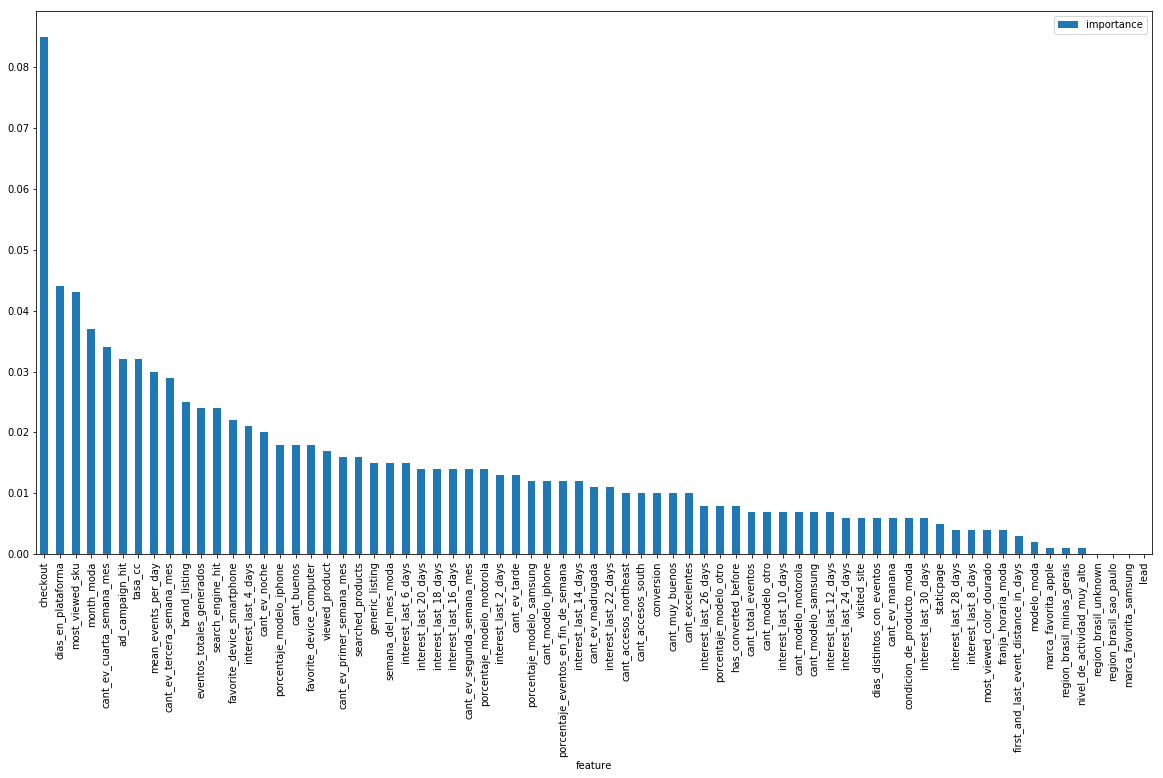

In [30]:
#ax =plot_importance(xgbf)
#fig = ax.figure
#fig.set_size_inches(10, 10)

importances = pd.DataFrame({'feature':features_names,'importance':np.round(xgbf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

importances.plot.bar(figsize=(20,10))

In [ ]:
xgbf.fit(x,y, eval_metric='aucpr')
pred = (xgbf.predict_proba(z)[:,1])

In [24]:
z.shape

(19415, 71)

In [25]:
# Tomo las personas que tengo que predecir
persons = test_set['person']

# Les agrego los labels que predije
submit = pd.DataFrame({'label': pred, 'person': persons})

# Creo Data Frame de sumit
submit = submit[['person', 'label']]

# Envío a archivo csv
submit.to_csv('../submits/xgboost_gaby.csv', index=False)

# Cuento cantidad de conversiones
no_conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print('Cantidad de no conversiones: ' + str(no_conversiones))

conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print('Cantidad de conversiones: ' + str(conversiones))

Cantidad de no conversiones: 15631
Cantidad de conversiones: 3784


In [26]:
submit.shape

(19415, 2)